## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import itertools
from string import punctuation
import nltk
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectFpr, chi2, mutual_info_classif

import matplotlib.pyplot as plt
import seaborn as sns

category = ['Sydney', 'Melbourne', 'Brisbane', 'Perth']

## Prepping raw tweet data

In [2]:
train = pd.read_csv('train-raw.tsv', sep='\t', names=['label', 'body_text']).iloc[1:].reset_index(drop=True)

dev = pd.read_csv('dev-raw.tsv', sep='\t').reset_index()
dev.drop('level_0', axis=1, inplace=True)
dev.columns = ['label', 'body_text']

test = pd.read_csv('test-raw.tsv', sep='\t').reset_index().rename({'level_0': 'Id'},axis=1).set_index('Id').drop('level_1',axis=1)
test.columns = ['body_text']

In [3]:
X_train, y_train, X_dev, y_dev = train['body_text'], train['label'], dev['body_text'], dev['label']
# dev meta is used for our meta-classifier
X_test = test['body_text']

## Feature Selection
- Based on the presence of a word (rather than frequency
- `binary=True` flag so all non-zero counts are one

In [4]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_unicode(text):
    return ' '.join([i for i in text.split() if '\\' not in i])

def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def preprocess(text):
    no_links = remove_links(text)  
    no_unicode = remove_unicode(no_links)
    no_punc = remove_punc(no_unicode)
    no_num = remove_num(no_punc)
    cleaned = remove_stopwords(no_num)
    return tknzr.tokenize(cleaned)

In [ ]:
binary_vectorizer = CountVectorizer(analyzer=preprocess, binary=True, min_df=2).fit(X_train)
X_binary = binary_vectorizer.transform(X_train) # word in presence of label

# should be a list of unique words in every train tweet 
features = binary_vectorizer.get_feature_names() 

Feature Selection:
- False Positive Rate at alpha=0.2 significance level using chi2
- Top 50 percent of mutual information

In [ ]:
k_best = SelectFpr(chi2, alpha=0.2).fit(X_binary, y_train)
k_best_features_chi2 = [features[i] for i in k_best.get_support(indices=True)]

In [ ]:
k_best = SelectPercentile(mutual_info_classif, percentile=50).fit(X_binary, y_train)
k_best_features_MI = [features[i] for i in k_best.get_support(indices=True)]

In [ ]:
k_best_features = set(k_best_features_chi2 + k_best_features_MI)
# output to text so we don't have to keep redoing this step...
with open('best_features.txt', 'w') as f:
    for item in k_best_features:
        f.write("%s\n" % item)

In [5]:
K_BEST_FEATURES = list()
with open('best_features.txt', 'r') as f:
    for line in f:
        K_BEST_FEATURES.extend(line.strip().split('\n'))

def feature_select(text):
    no_links = remove_links(text)  
    no_unicode = remove_unicode(no_links)
    no_punc = remove_punc(no_unicode)
    no_num = remove_num(no_punc)
    cleaned = remove_stopwords(no_num)
    tokens = tknzr.tokenize(cleaned)
    return [i for i in tokens if i in K_BEST_FEATURES]

### Feature Selection (freq)
- NB
- LR

Use the top 80% features (This is the freq variant of our data set)

In [6]:
vectorizer = CountVectorizer(analyzer=feature_select).fit(X_train)
X_train_freq = vectorizer.transform(X_train)
X_dev_freq = vectorizer.transform(X_dev) # We fit Dev to Train
X_test_freq = vectorizer.transform(X_test) # We fit Test to Train

### Feature Selection (`tfidf`)
- SVM

Use the top 80% features
(This is the `tfidf` variant of our data set)

In [7]:
tfidf = TfidfTransformer() # transform frequency to tfidf
X_train_tfidf = tfidf.fit_transform(X_train_freq)
X_dev_tfidf = tfidf.fit_transform(X_dev_freq)
X_test_tfidf = tfidf.fit_transform(X_test_freq)

## Run our Classifiers
- Including lemmatization of tweets
- `y_pred` is our prediction on the real `test` data

In [8]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [9]:
def report(clf, X_test, y_test):
    # generates a report summary
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred,target_names=category))
    print(f'Accuracy: {100*accuracy_score(y_pred, y_test):.2f}%')
    df = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=category), index=category, columns=category)
    sns.heatmap(df, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.yticks(rotation=0)
    plt.show()
    return y_pred

def random_search_tune(X_train, y_train, estimator, parameters):
    # randomised search for hyperparameters
    rs = RandomizedSearchCV(estimator, parameters, n_iter=50, cv=5, random_state=0, n_jobs=-1)
    rs_fit = rs.fit(X_train, y_train)
    display(rs_fit.cv_results_)
    return rs_fit.best_params_

### Multinomial Naive Bayes
- Uses a frequency based feature space
- Takes the top 80% features

Multinomial NB
              precision    recall  f1-score   support

      Sydney       0.31      0.48      0.38      9324
   Melbourne       0.42      0.23      0.29      9325
    Brisbane       0.35      0.30      0.33      9325
       Perth       0.33      0.35      0.34      9326

   micro avg       0.34      0.34      0.34     37300
   macro avg       0.35      0.34      0.33     37300
weighted avg       0.35      0.34      0.33     37300

Accuracy: 34.00%


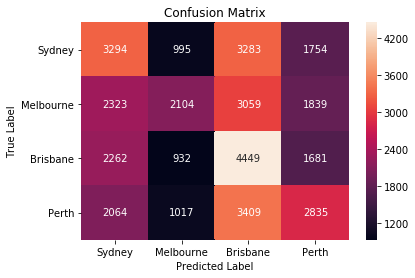

In [10]:
print('Multinomial NB')
clf1 = MultinomialNB().fit(X_train_freq, y_train)
report(clf1, X_dev_freq, y_dev)
to_output = clf1.predict(X_test_freq)
pd.DataFrame(to_output, index=test.index,columns=['Class']).to_csv("naive_bayes_predictions.csv")

### Support Vector Machines (One Vs Rest)
- Uses a `tfidf` feature space
- Takes the top 80% features

In [11]:
print('One vs Rest SVM') 
clf2 = LinearSVC(max_iter=10000, random_state=0, tol=1e-05).fit(X_train_tfidf, y_train)
to_output = clf2.predict(X_test_freq)
pd.DataFrame(to_output, index=test.index,columns=['Class']).to_csv("svm_predictions.csv")

One vs Rest SVM


### Multi-Class Logistic Regression
- Uses a frequency based feature space
- Takes the top 80% features

In [12]:
print('Logistic Regression (Multi-Class)') 
clf3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train_freq, y_train)
to_output = clf3.predict(X_test_freq)
pd.DataFrame(to_output, index=test.index,columns=['Class']).to_csv("logistic_predictions.csv")

Logistic Regression (Multi-Class)


## Stacked Ensemble Learner

In [13]:
from mlxtend.classifier import StackingCVClassifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
stacked_clf1 = RandomForestClassifier(n_estimators=100, min_samples_split=50, 
                              min_samples_leaf=1, criterion='gini', n_jobs=-1)
stacked_clf2 = MultinomialNB()
stacked_clf3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=-1)

sclf = StackingCVClassifier(classifiers=[stacked_clf1, stacked_clf2, stacked_clf3],
                            meta_classifier=lr, use_probas=True)

In [16]:
sclf.fit(X_train_tfidf, y_train.replace(category,[0,1,2,3]))

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_...penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)],
           cv=2, drop_last_proba=False,
           meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
           n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
           shuffle=True, store_train_meta_features=False, stratify=True,
           use_clones=True, use_features_in_secondary=False,
           use_probas=True, verbo

              precision    recall  f1-score   support

      Sydney       0.34      0.31      0.33      9324
   Melbourne       0.38      0.29      0.33      9325
    Brisbane       0.37      0.28      0.32      9325
       Perth       0.30      0.48      0.37      9326

   micro avg       0.34      0.34      0.34     37300
   macro avg       0.35      0.34      0.34     37300
weighted avg       0.35      0.34      0.34     37300

Accuracy: 33.91%


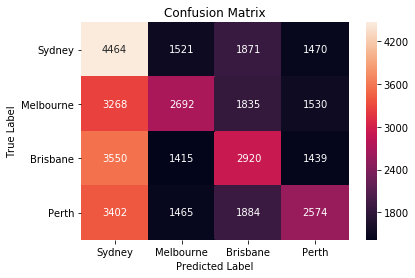

In [17]:
preds = pd.Series(sclf.predict(X_dev_tfidf)).replace([0,1,2,3], category)
print(classification_report(y_dev, preds,target_names=category))
print(f'Accuracy: {100*accuracy_score(preds, y_dev):.2f}%')
df = pd.DataFrame(confusion_matrix(y_dev, preds, labels=category), index=category, columns=category)
sns.heatmap(df, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.yticks(rotation=0)
plt.show()
to_output = sclf.predict(X_test_freq)
pd.DataFrame(to_output, index=test.index,columns=['Class']).to_csv("stacked_ensemble_predictions.csv")